In [1]:
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.style as style

style.use('seaborn-pastel')

In [5]:
# %load src/latency_aware_simulator.py
import random
from collections import namedtuple

import numpy as np
import simpy

LatencyDatum = namedtuple(
    'LatencyDatum',
    ('t_queued', 't_processing', 't_total')
)


class LatencyAwareRequestSimulator(object):
    """ Simulates a M/G/k process common in request processing (computing)

    :param worker_desc: A list of ints of capacities to construct workers with
    :param local_balancer: A function which takes the current request number
        the list of workers and the request time and returns the index of the
        worker to send the next request to
    :param latency_fn: A function which takes the curent request number and
        returns the number of milliseconds a request took to process
    :param number_of_requests: The number of requests to run through the
        simulator
    :param request_per_s: The rate of requests per second.
    """

    def __init__(
            self, worker_desc, load_balancer, latency_fn,
            number_of_requests, request_per_s):
        self.worker_desc = worker_desc
        self.load_balancer = load_balancer
        self.latency_fn = latency_fn
        self.number_of_requests = int(number_of_requests)
        self.request_interval_ms = 1. / (request_per_s / 1000.)
        self.data = []
        self.requests_per_worker = {}

    def simulate(self):
        # Setup and start the simulation
        random.seed(1)
        np.random.seed(1)

        self.env = simpy.Environment()
        self.workers = []
        idx = 0
        for cap in self.worker_desc:
            self.workers.append(simpy.Resource(self.env, capacity=cap))
            self.requests_per_worker[idx] = 0
            idx += 1
        self.env.process(self.generate_requests())
        self.env.run()

    def generate_requests(self):
        for i in range(self.number_of_requests):
            t_processing = self.latency_fn(i)
            idx = self.load_balancer(i, self.workers, t_processing)
            self.requests_per_worker[idx] += 1
            worker = self.workers[idx]
            response = self.process_request(
                i, worker, t_processing
            )
            self.env.process(response)
            # Exponential inter-arrival times == Poisson
            arrival_interval = random.expovariate(
                1.0 / self.request_interval_ms
            )
            yield self.env.timeout(arrival_interval)

    def process_request(self, request_id, worker, duration):
        """ Request arrives, possibly queues, and then processes"""
        t_arrive = self.env.now

        with worker.request() as req:
            yield req
            t_start = self.env.now
            t_queued = t_start - t_arrive

            yield self.env.timeout(duration)

            t_done = self.env.now
            t_processing = t_done - t_start
            t_total_response = t_done - t_arrive

            datum = LatencyDatum(t_queued, t_processing, t_total_response)
            self.data.append(datum)


def run_simulation(
        worker_desc, load_balancer, num_requests, request_per_s, latency_fn):
    simulator = LatencyAwareRequestSimulator(
        worker_desc, load_balancer, latency_fn,
        num_requests, request_per_s
    )
    simulator.simulate()
    return simulator.data, simulator.requests_per_worker


In [6]:
def bounded_pareto(mean, shape, bound):
    # mean = scale * shape / (shape - 1)
    # solve for scale given mean and shape (aka skew) 
    scale = mean - mean / shape 
    def latency(request):
        return min(bound, (np.random.pareto(shape) + 1) * scale)
    return latency

def split_bounded_pareto(params, weights):
    assert len(params) == len(weights)
    distributions = [bounded_pareto(*(p)) for p in params] 
    def latency(request):
        choice = np.random.choice(distributions, p=weights)
        return choice(request)
    return latency

# latency_cutoffs = list of cutoffs
def fast_lane_lb(latency_cutoffs):        
    def balance(request_id, workers, t_processing):
        assert len(workers) == len(latency_cutoffs)
        index = 0
        while index < len(latency_cutoffs) - 1 and latency_cutoffs[index] < t_processing:
            index += 1
        return index
    return balance

In [7]:
NUM_REQUESTS = 40000
QPS = 1000
SERVERS = 10

latency_function = split_bounded_pareto(
    [(0.4, 2, 3), (12, 2, 30)],
    [0.5, 0.5]
)

data_single, w_single = run_simulation((SERVERS,), lambda i, x, l: 0, NUM_REQUESTS,
                                       QPS, latency_function)
single_slowdown = [i.t_total / i.t_processing for i in data_single]

average_latency = np.mean([i.t_processing for i in data_single])
stddev = np.sqrt(np.var([i.t_processing for i in data_single]))
print(w_single, average_latency)

latency_cutoffs = [average_latency, 10]
data_multi, w_multi = run_simulation((3, SERVERS - 3), fast_lane_lb(latency_cutoffs), NUM_REQUESTS,
                            QPS, latency_function)
print("Min", min([i.t_processing for i in data_multi]))
AVG_RESPONSE_MS = np.mean([i.t_processing for i in data_multi])
print("Avg", AVG_RESPONSE_MS)
print("NumFast", sum([i.t_processing < 2 for i in data_multi]), NUM_REQUESTS)
print(w_multi)
multi_slowdown = [i.t_total / i.t_processing for i in data_multi]

raw_queueing_options = {
    'Single Queue': data_single,
    'Fast Lane': data_multi 
}

slowdown_options = {
    'Single Queue Slowdown': single_slowdown,
    'Fast Lane Slowdown': multi_slowdown,
}

latency_options = {
    'Single Queue Latency': [i.t_total for i in data_single],
    'Fast Lane Latency': [i.t_total for i in data_multi]
}

print()
print("Latency results")
print("------------------")
hdr = "{0:24} | {1:>7} | {2:>10} | {3:>7} | {4:>7} | {5:>7} | {6:>7} |".format(
"Strategy", "mean", "var", "p50", "p95", "p99", "p99.9")
print(hdr)
for opt in sorted(latency_options.keys()):
    mean = np.mean(latency_options[opt])
    var = np.var(latency_options[opt])
    percentiles = np.percentile(latency_options[opt], [50, 95, 99, 99.9])
    print ("{0:24} | {1:7.2f} | {2:10.2f} | {3:7.2f} | {4:7.2f} | {5:>7.2f} | {6:7.2f} |".format(
        opt, mean, var, percentiles[0], percentiles[1], percentiles[2],
        percentiles[3]
    ))
    
print("\nSlowdown results")
print("------------------")
hdr = "{0:24} | {1:>7} | {2:>10} | {3:>7} | {4:>7} | {5:>7} | {6:>7} |".format(
"Strategy", "mean", "var", "p50", "p95", "p99", "p99.9")
print(hdr)
for opt in sorted(slowdown_options.keys()):
    mean = np.mean(slowdown_options[opt])
    var = np.var(slowdown_options[opt])
    percentiles = np.percentile(slowdown_options[opt], [50, 95, 99, 99.9])
    print ("{0:24} | {1:7.2f} | {2:10.2f} | {3:7.2f} | {4:7.2f} | {5:>7.2f} | {6:7.2f} |".format(
        opt, mean, var, percentiles[0], percentiles[1], percentiles[2],
        percentiles[3]
    ))

{0: 40000} 5.575176453042038
Min 0.2000010786978237
Avg 5.575176453042038
NumFast 19877 40000
{0: 20069, 1: 19931}

Latency results
------------------
Strategy                 |    mean |        var |     p50 |     p95 |     p99 |   p99.9 |
Fast Lane Latency        |    6.49 |      60.96 |    3.00 |   22.71 |   31.31 |   40.25 |
Single Queue Latency     |    5.68 |      45.20 |    4.92 |   19.23 |   30.00 |   30.71 |

Slowdown results
------------------
Strategy                 |    mean |        var |     p50 |     p95 |     p99 |   p99.9 |
Fast Lane Slowdown       |    1.10 |       0.09 |    1.00 |    1.69 |    2.54 |    3.61 |
Single Queue Slowdown    |    1.19 |       1.94 |    1.00 |    1.11 |    8.06 |   18.98 |


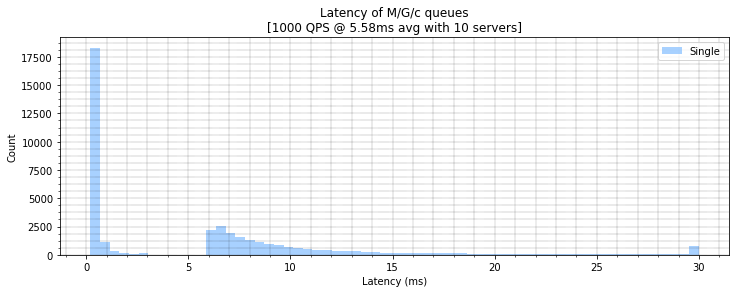

In [8]:
fig1, ax = plt.subplots(figsize=(12,4))


#bplot1 = ax.boxplot(data, whis=[1,99],showfliers=False,flierprops=flier, labels=opts,
#                    patch_artist=True, vert=False)
#color_bplot(bplot1, 'black', 'lightblue')

plt.hist([d.t_processing for d in data_single], bins='auto', density=False, alpha=0.8, label='Single')

plt.title("Latency of M/G/c queues\n"
          "[{0} QPS @ {1:2.2f}ms avg with {2} servers]".format(
    QPS, AVG_RESPONSE_MS, SERVERS)
)

plt.minorticks_on()
plt.grid(which='major', linestyle=':', linewidth='0.4', color='black')
plt.grid(which='minor', linestyle=':', linewidth='0.4', color='black')
plt.legend(loc='upper right')
plt.xlabel('Latency (ms)')
plt.ylabel('Count')

plt.show()

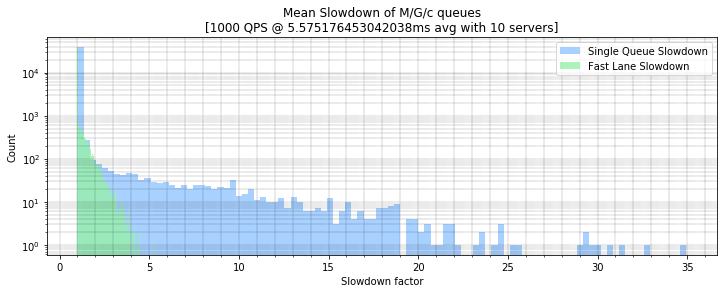

In [12]:
fig1, ax = plt.subplots(figsize=(12,4))
ax.set_yscale('log')


for label, datum in reversed(sorted(slowdown_options.items())):
    plt.hist(datum, bins=100, density=False, alpha=0.8, label=label)

plt.title("Mean Slowdown of M/G/c queues\n"
          "[{0} QPS @ {1}ms avg with {2} servers]".format(
    QPS, AVG_RESPONSE_MS, SERVERS)
)

plt.minorticks_on()
plt.grid(which='major', linestyle=':', linewidth='0.4', color='black')
plt.grid(which='minor', linestyle=':', linewidth='0.4', color='black')
plt.legend(loc='upper right')
plt.xlabel('Slowdown factor')
plt.ylabel('Count')

plt.show()